In [14]:
import matplotlib.pyplot as plt

from pyspark.sql import (
    functions as F,
    Row,
    SparkSession,
)

In [15]:
# init spark session
spark = SparkSession.builder.master('local[*]').config('spark.ui.port', '4040').getOrCreate()
spark

# Overview

In [16]:
review_fp = "hdfs://namenode:9000/preprocessed"
df = spark.read.parquet(review_fp, header=True, inferSchema=True)
df.printSchema()
print(f'Total reviews: {df.count()}')
df.show(5)

root
 |-- review: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- place_index: integer (nullable = true)
 |-- sentiment: string (nullable = true)

Total reviews: 4016
+--------------------+------+-----------+---------+
|              review|rating|place_index|sentiment|
+--------------------+------+-----------+---------+
|3 miếng gà 105k n...|     1|          0| negative|
|Thật tuyệt với gà...|     5|          0| positive|
|Gà ướp vừa vị , m...|     5|          0| positive|
|Quán sạch , đẹp ,...|     5|          0| positive|
|Nhân_viên bự con ...|     5|          0| positive|
+--------------------+------+-----------+---------+
only showing top 5 rows



In [17]:
# Total Rows & Columns
print(f"Total rows: {df.count()}")
print(f"Total columns: {len(df.columns)}\n")

print('Overview of columns:')
df.describe().show()

print('Count by rating:')
df.groupBy('rating').count().orderBy('rating').show()

print('Count by place_index:')
df.groupBy('place_index').count().orderBy('place_index').show()

Total rows: 4016
Total columns: 4

Overview of columns:
+-------+--------------------+-----------------+------------------+---------+
|summary|              review|           rating|       place_index|sentiment|
+-------+--------------------+-----------------+------------------+---------+
|  count|                4016|             4016|              4016|     4016|
|   mean|                NULL|4.145916334661354|10.418077689243027|     NULL|
| stddev|                NULL|1.528190314011222| 6.318547832750799|     NULL|
|    min|( không chỉ chi_n...|                1|                 0| negative|
|    max|               🥳 🙌|                5|                21| positive|
+-------+--------------------+-----------------+------------------+---------+

Count by rating:
+------+-----+
|rating|count|
+------+-----+
|     1|  669|
|     2|   92|
|     3|  148|
|     4|  182|
|     5| 2925|
+------+-----+

Count by place_index:
+-----------+-----+
|place_index|count|
+-----------+-----+
|       

# *Distribution of ratings*

Based on the chart, it’s clear that most users gave 5-star ratings (**2624 reviews**), showing that they were really satisfied with the service.\
The number of lower ratings like 1 (**496 reviews**), 2 (**68 reviews**), or 3 (**113 reviews**) stars is quite small in comparison, implying that only a few people had negative experiences.

The strong concentration in high ratings suggests that the overall user feedback is very positive.

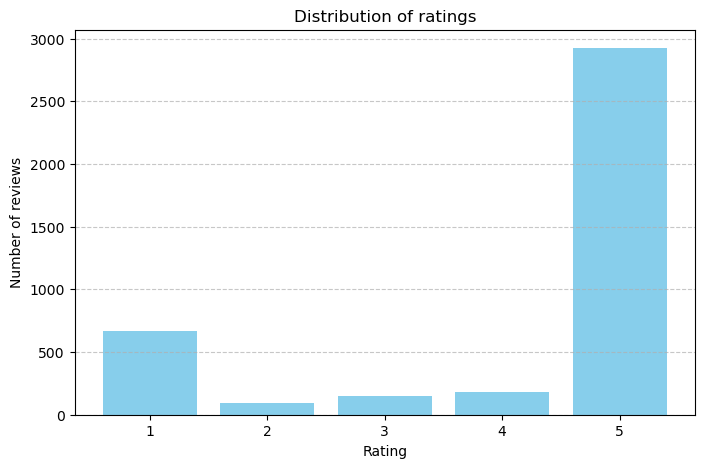

In [18]:
rating_distribution = df.groupBy('rating').count().orderBy('rating')

data = rating_distribution.collect()
ratings = [row['rating'] for row in data]
counts = [row['count'] for row in data]

plt.figure(figsize=(8, 5))
plt.title('Distribution of ratings')

plt.bar(ratings, counts, color='skyblue')

plt.xlabel('Rating')
plt.xticks(ratings)
plt.ylabel('Number of reviews')

plt.grid(axis='y', linestyle='--', alpha=0.7);

# `place_index` *by average rating*

From the chart, we can see that the average ratings across different places are generally high, most of them above 4.\
This shows that users tend to be quite satisfied overall. Place index 7 stands out with the highest average, close to 5 stars, while place 8 has the lowest, of below 4 stars.

The moderate variation between places suggests that service quality is fairly consistent, though some places clearly perform better than others.

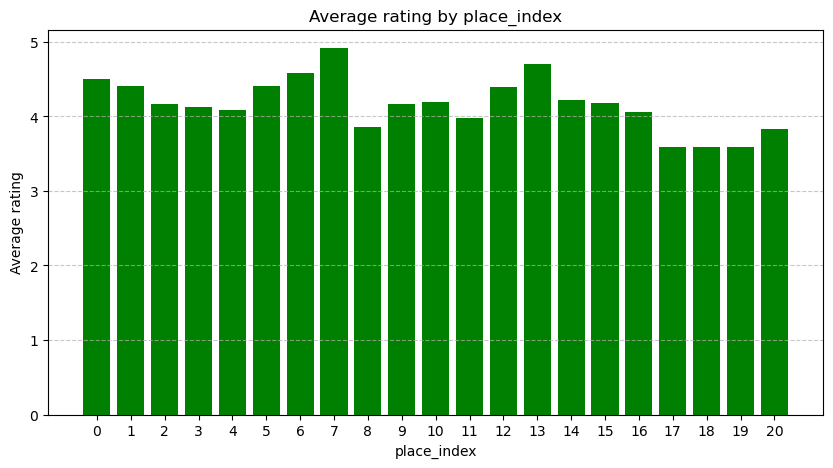

In [20]:
av_rating_df = df.groupBy('place_index').avg('rating').orderBy('place_index').toPandas()

figure = plt.figure(figsize=(10, 5))
ax = figure.add_subplot(111)

ax.set_title('Average rating by place_index')
ax.bar(av_rating_df.index, av_rating_df['avg(rating)'], color='green')

ax.set_xticks(av_rating_df.index)
ax.set_xlabel('place_index')
ax.set_ylabel('Average rating')
plt.grid(axis='y', linestyle='--', alpha=0.7);

# **Word Count**

To better understand the common themes in the reviews, we analyzed the commonly used words within the reviews.

In [21]:
import re
from string import punctuation

import pandas as pd
import numpy as np

The list of Vietnamese stopwords are provided at [`stopwords/vietnamese-stopwords`](https://github.com/stopwords/vietnamese-stopwords)

In [22]:
!wget -qO vietnamese-stopwords-dash.txt https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/refs/heads/master/vietnamese-stopwords-dash.txt

In [23]:
stopwords_path = "vietnamese-stopwords-dash.txt"
with open(stopwords_path, encoding='utf-8') as file:
    stopwords = {line.strip() for line in file}

In [29]:
def word_tokenize(row):
    return [(
        word.lower(), row['rating'],
        row['sentiment'], row['place_index']
        ) for word in row['review'].split()
    ]

tokenized_rdd = df.rdd.flatMap(word_tokenize)

In [43]:
count_global = tokenized_rdd.map(lambda row: ((row[0], ), 1))
wc_global = count_global.reduceByKey(lambda x, y: x + y)

# By rating
count_by_rating = tokenized_rdd.map(lambda row: ((row[0], row[1]), 1))
wc_rating = count_by_rating.reduceByKey(lambda x, y: x + y)

# By sentiment & place_index
count_by_sent_place = tokenized_rdd.map(lambda row: ((row[0], row[2], row[3]), 1))
wc_sent_place = count_by_sent_place.reduceByKey(lambda x, y: x + y)

# By sentiment
count_by_sent = tokenized_rdd.map(lambda row: ((row[0], row[2]), 1))
wc_sent = count_by_sent.reduceByKey(lambda x, y: x + y)

In [47]:
stopwords.update(set(punctuation))

def is_valid_key(key):
    # single string (wc_global)
    if isinstance(key, str): word = key
    # tuple (wc_rating, wc_sent_place,...)
    elif isinstance(key, tuple): word = key[0]
    return (
        word not in stopwords and
        not re.fullmatch(r'^\W+$', word) and # remove punctuation
        not re.fullmatch(r'^\d+$', word) # remove numbers
    )

filtered_global = wc_global.filter(lambda row: is_valid_key(row[0][0]))
filtered_rating = wc_rating.filter(lambda row: is_valid_key(row[0][0]))
filtered_sent = wc_sent.filter(lambda row: is_valid_key(row[0][0]))
filtered_sent_place = wc_sent_place.filter(lambda row: is_valid_key(row[0][0]))

The word frequency table shows that users often mention aspects related to service quality and food:

- In terms of **service**, words like 'nhân_viên', 'phục_vụ', 'nhiệt_tình', 'thân_thiện', and 'dễ_thương' appear frequently, indicating a generally positive impression of customer service.
- In terms of **food**, words such as 'ngon', 'gà', 'giòn', 'món', and 'chiên' suggest that many users were satisfied with the food quality, especially chicken – a key product of KFC.
- Some negative or neutral words like 'tệ', 'đợi' are present, but with lower frequency, implying negative experiences exist but are not dominant.

In [56]:
global_df = spark.createDataFrame([Row(word=k[0], count=v) for k, v in filtered_global.collect()])

print('Top 50 frequency keywords:')
global_df.orderBy('count', ascending=False).show(50, truncate=False)

Top 50 frequency keywords:
+----------+-----+
|word      |count|
+----------+-----+
|nhân_viên |1835 |
|ngon      |1431 |
|gà        |1072 |
|đồ        |944  |
|nhiệt_tình|754  |
|phục_vụ   |663  |
|món       |518  |
|kfc       |483  |
|quán      |444  |
|dễ_thương |403  |
|thân_thiện|387  |
|không_gian|318  |
|đi        |307  |
|sạch_sẽ   |305  |
|thái_độ   |270  |
|giòn      |253  |
|mua       |239  |
|đợi       |235  |
|tệ        |228  |
|nhà_hàng  |203  |
|nv        |203  |
|dịch_vụ   |191  |
|nóng      |186  |
|vui_vẻ    |177  |
|ghé       |177  |
|order     |175  |
|giao      |171  |
|nghiệm    |167  |
|nha       |165  |
|lắm       |164  |
|hơi       |164  |
|khách_hàng|163  |
|đơn       |160  |
|chi_nhánh |156  |
|trải      |155  |
|miếng     |148  |
|thoáng    |146  |
|quản_lý   |146  |
|mát       |144  |
|xe        |144  |
|rán       |143  |
|combo     |143  |
|đông      |142  |
|hàng      |141  |
|gọi       |137  |
|ok        |137  |
|chỗ       |136  |
|mấy       |133  |
|tuy

# Word Cloud

Wordcloud is a visualization tool that displays the frequency of words in a text dataset. This section uses the Python library [wordcloud](https://pypi.org/project/wordcloud/) to create a Wordcloud image from customer's reviews 

In [ ]:
from wordcloud import WordCloud
# Create WordCloud
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white',
                      colormap='viridis')

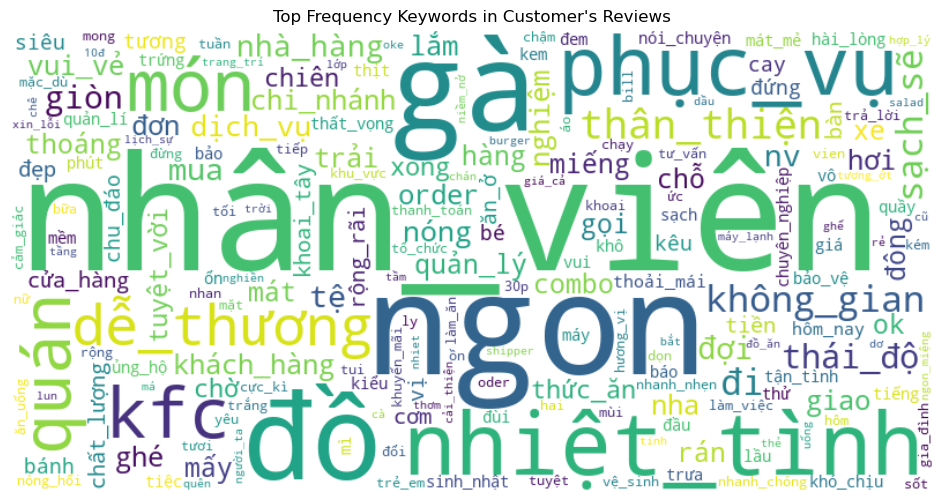

In [ ]:
wordcloud_dict = {key[0]: val for key, val in filtered_global.collect()}

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud.generate_from_frequencies(wordcloud_dict), interpolation='bilinear')
plt.axis("off")
plt.title("Top Frequency Keywords in Customer's Reviews");

# Word Count by Sentiment

The word count for each sentiment (negative, postitive, neural) is examined to identify the most frequent terms associated with that sentiment. The table below displays the top words appearing most often in negative sentiment expressions, along with their respective frequency counts

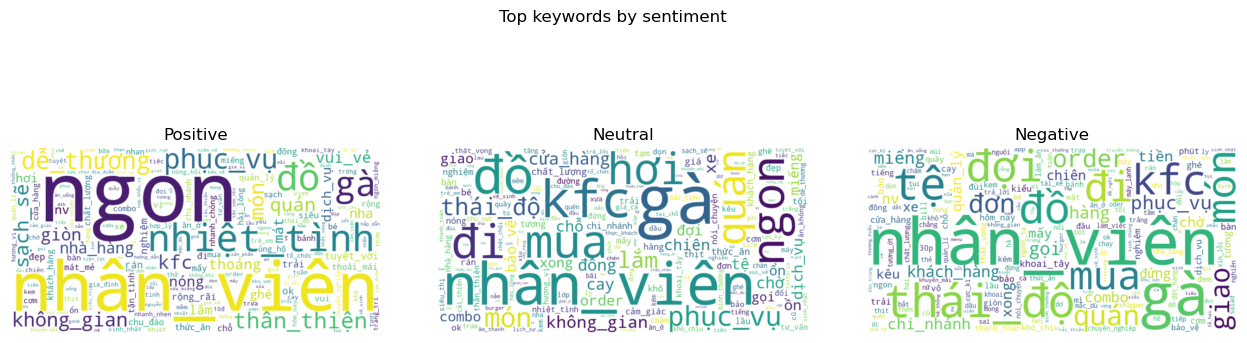

In [ ]:
# Create dataframe
temp_dict = {
    star: {key[0]: val for key, val in filtered_rating.filter(lambda x: x[0][1] == star).collect()}
    for star in range(1, 6)
}

fig = plt.figure(figsize=(13, 10))
axes = fig.subplot_mosaic([[1, 2, 3], [4, 5, '.']])

fig.tight_layout()
fig.suptitle("Top keywords by rating")
for star, freq_dict in temp_dict.items():
    axes[star].imshow(wordcloud.generate_from_frequencies(temp_dict[star]), interpolation='bilinear')
    axes[star].axis("off")
    axes[star].set_title(f"{star}-star Reviews");

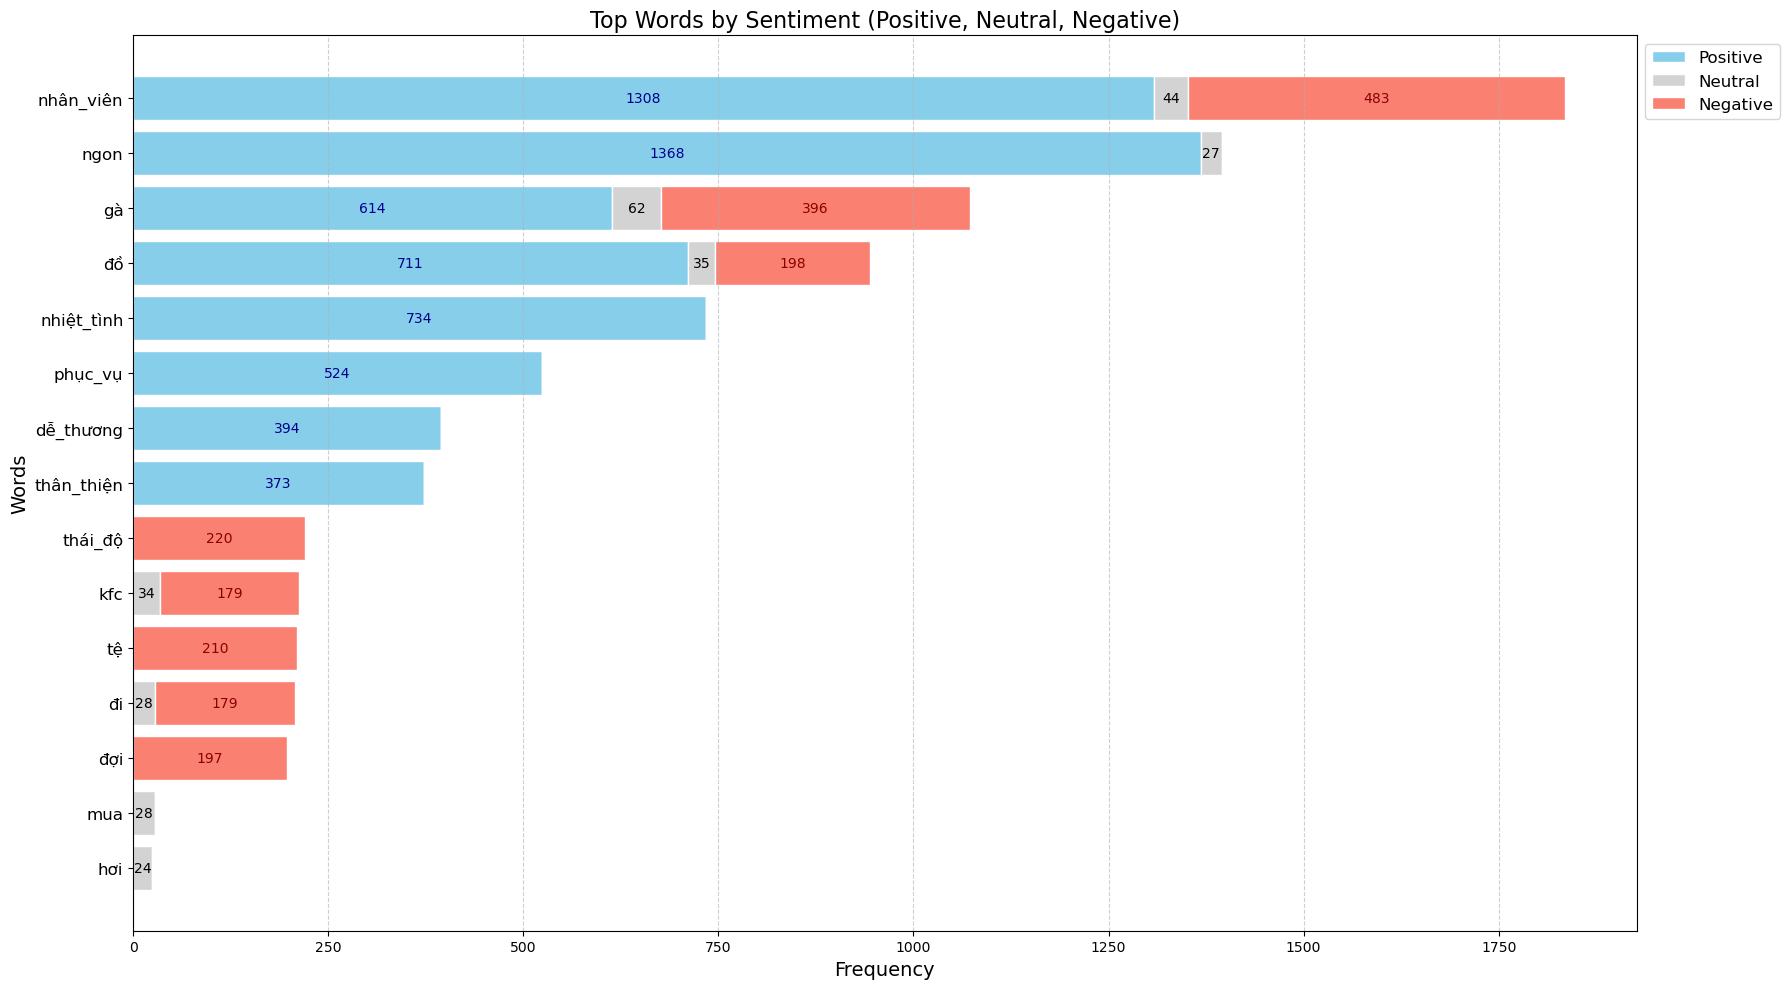

In [ ]:
top_words = {
    sentiment: {
        key[0]: count for key, count in (filtered_sent
            .filter(lambda x: x[0][1] == sentiment)
            .takeOrdered(8, key=lambda x: x[1])
        )
    }
    for sentiment in ['positive', 'neutral', 'negative']
}

# for sentiment in ['positive', 'neutral', 'negative']:
#     top_words[sentiment] = (
#         sent_df.filter(F.col('sentiment') == sentiment)
#         .orderBy(F.col('count').desc())
#         .limit(8)
#         .select('word', 'count')
#         .rdd.collectAsMap()
#     )

all_words = list(set(
    list(top_words['positive'].keys()) + 
    list(top_words['neutral'].keys()) + 
    list(top_words['negative'].keys())
))

df_plot = pd.DataFrame({
    'Word': all_words,
    'Positive': [top_words['positive'].get(word, 0) for word in all_words],
    'Neutral': [top_words['neutral'].get(word, 0) for word in all_words],
    'Negative': [top_words['negative'].get(word, 0) for word in all_words]
})

df_plot['Total'] = df_plot['Positive'] + df_plot['Neutral'] + df_plot['Negative']
df_plot = df_plot.sort_values('Total', ascending=True)

# Visualize stacked bar
plt.figure(figsize=(18, 10))

p1 = plt.barh(df_plot['Word'], df_plot['Positive'], 
              color='skyblue', label='Positive', edgecolor='white')
p2 = plt.barh(df_plot['Word'], df_plot['Neutral'], 
              left=df_plot['Positive'],
              color='lightgray', label='Neutral', edgecolor='white')
p3 = plt.barh(df_plot['Word'], df_plot['Negative'], 
              left=df_plot['Positive'] + df_plot['Neutral'],
              color='salmon', label='Negative', edgecolor='white')

for i, word in enumerate(df_plot['Word']):
    # Positive
    if df_plot['Positive'].iloc[i] > 0:
        plt.text(df_plot['Positive'].iloc[i]/2, i,
                str(df_plot['Positive'].iloc[i]), 
                va='center', ha='center', color='darkblue', fontsize=10)
    
    # Neutral
    if df_plot['Neutral'].iloc[i] > 0:
        plt.text(df_plot['Positive'].iloc[i] + df_plot['Neutral'].iloc[i]/2, i,
                str(df_plot['Neutral'].iloc[i]), 
                va='center', ha='center', color='black', fontsize=10)
    
    # Negative
    total_width = df_plot['Positive'].iloc[i] + df_plot['Neutral'].iloc[i] + df_plot['Negative'].iloc[i]
    if df_plot['Negative'].iloc[i] > 0:
        plt.text(df_plot['Positive'].iloc[i] + df_plot['Neutral'].iloc[i] + df_plot['Negative'].iloc[i]/2, i,
                str(df_plot['Negative'].iloc[i]), 
                va='center', ha='center', color='darkred', fontsize=10)

plt.yticks(range(len(df_plot['Word'])), df_plot['Word'], fontsize=12)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.title('Top Words by Sentiment (Positive, Neutral, Negative)', fontsize=16)
plt.legend(fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Word Count by Sentiment & Place_Index

In [84]:
# Tạo DataFrame từ filtered_sent_place
sent_place_df = spark.createDataFrame(
    [Row(word=k[0], sentiment=k[1], place=k[2], count=v) 
     for k, v in filtered_sent_place.collect()]
)

# Hiển thị top từ theo từng place, sắp xếp theo count
print('Top frequency keywords by place (ordered by count):')

# Lấy danh sách các place có trong dữ liệu
places = [row['place'] for row in sent_place_df.select('place').distinct().collect()]

for place in sorted(places):
    print(f"\nPlace {place}:")
    (sent_place_df.filter(F.col('place') == place)
        .orderBy('count', ascending=False)
        .show(10, truncate=False)) # Hiển thị top 10 từ mỗi place

Top frequency keywords by place (ordered by count):

Place 0:
+----------+---------+-----+-----+
|word      |sentiment|place|count|
+----------+---------+-----+-----+
|ngon      |positive |0    |72   |
|nhân_viên |positive |0    |65   |
|gà        |positive |0    |46   |
|nhiệt_tình|positive |0    |46   |
|đồ        |positive |0    |35   |
|phục_vụ   |positive |0    |24   |
|thân_thiện|positive |0    |20   |
|gà        |negative |0    |18   |
|dễ_thương |positive |0    |18   |
|quán      |positive |0    |17   |
+----------+---------+-----+-----+
only showing top 10 rows


Place 1:
+----------+---------+-----+-----+
|word      |sentiment|place|count|
+----------+---------+-----+-----+
|ngon      |positive |1    |82   |
|nhân_viên |positive |1    |81   |
|đồ        |positive |1    |45   |
|nhiệt_tình|positive |1    |41   |
|phục_vụ   |positive |1    |32   |
|dễ_thương |positive |1    |25   |
|thân_thiện|positive |1    |21   |
|không_gian|positive |1    |19   |
|gà        |positive |1    

In [85]:
sent_place_df = spark.createDataFrame(
    [Row(word=k[0], sentiment=k[1], place=k[2],count=v) 
     for k, v in filtered_sent_place.collect()]
)

print('Top 50 frequency keywords by rating:')
sent_place_df.orderBy('count', ascending=False).show(50, truncate=False)

Top 50 frequency keywords by rating:
+----------+---------+-----+-----+
|word      |sentiment|place|count|
+----------+---------+-----+-----+
|nhân_viên |positive |7    |96   |
|nhân_viên |positive |15   |93   |
|ngon      |positive |12   |93   |
|nhân_viên |positive |3    |89   |
|ngon      |positive |5    |88   |
|nhân_viên |positive |12   |88   |
|ngon      |positive |8    |84   |
|ngon      |positive |1    |82   |
|ngon      |positive |7    |82   |
|nhân_viên |positive |1    |81   |
|ngon      |positive |4    |80   |
|ngon      |positive |15   |79   |
|ngon      |positive |14   |78   |
|nhân_viên |positive |5    |77   |
|nhân_viên |positive |14   |75   |
|ngon      |positive |0    |72   |
|ngon      |positive |16   |66   |
|ngon      |positive |13   |66   |
|nhân_viên |positive |8    |66   |
|nhân_viên |positive |0    |65   |
|ngon      |positive |11   |61   |
|ngon      |positive |21   |60   |
|đồ        |positive |12   |60   |
|nhân_viên |positive |13   |59   |
|ngon      |positi

In [86]:
# Tạo dictionary ánh xạ place number sang tên
place_names = {
    0: 'Phan Huy Ích',
    1: 'Nguyễn Văn Quá',
    2: 'Pandora',
    3: 'Tân Sơn Nhì',
    4: 'Aeon Mall Tân Phú',
    5: 'Phạm Văn Chiêu',
    6: 'Tops Market',
    7: 'Đồng Đen',
    8: 'Maximark Cộng Hòa',
    9: 'Tân Kỳ Tân Quý',
    10: 'Coopmart Nguyễn Ảnh Thủ',
    11: 'Thống Nhất',
    12: 'Nguyễn Sơn',
    13: 'Vincom Quang Trung',
    14: 'Lý Thường Kiệt',
    15: 'Ngô Gia Tự',
    16: 'Xóm Củi',
    18: 'Quang Trung',
    19: 'Lê Văn Việt',
    20: 'Cách Mạng Tháng 8',
    21: 'Âu Cơ'
}

@F.udf()
def get_place_name(place_num):
    return place_names.get(place_num, f"Unknown Place {place_num}")

sent_place_df = sent_place_df.withColumn("place_name", get_place_name(F.col("place")))

print('Top frequency keywords by place (with place names):')


named_places = sorted([p for p in places if p in place_names])

for place_num in named_places:
    place_name = place_names[place_num]
    print(f"\nPlace {place_num} - {place_name}:")
    (sent_place_df.filter(F.col('place') == place_num)
        .orderBy('count', ascending=False)
        .select('word', 'sentiment', 'count', 'place_name')
        .show(10, truncate=False))

Top frequency keywords by place (with place names):

Place 0 - Phan Huy Ích:
+----------+---------+-----+------------+
|word      |sentiment|count|place_name  |
+----------+---------+-----+------------+
|ngon      |positive |72   |Phan Huy Ích|
|nhân_viên |positive |65   |Phan Huy Ích|
|gà        |positive |46   |Phan Huy Ích|
|nhiệt_tình|positive |46   |Phan Huy Ích|
|đồ        |positive |35   |Phan Huy Ích|
|phục_vụ   |positive |24   |Phan Huy Ích|
|thân_thiện|positive |20   |Phan Huy Ích|
|gà        |negative |18   |Phan Huy Ích|
|dễ_thương |positive |18   |Phan Huy Ích|
|quán      |positive |17   |Phan Huy Ích|
+----------+---------+-----+------------+
only showing top 10 rows


Place 1 - Nguyễn Văn Quá:
+----------+---------+-----+--------------+
|word      |sentiment|count|place_name    |
+----------+---------+-----+--------------+
|ngon      |positive |82   |Nguyễn Văn Quá|
|nhân_viên |positive |81   |Nguyễn Văn Quá|
|đồ        |positive |45   |Nguyễn Văn Quá|
|nhiệt_tình|positi

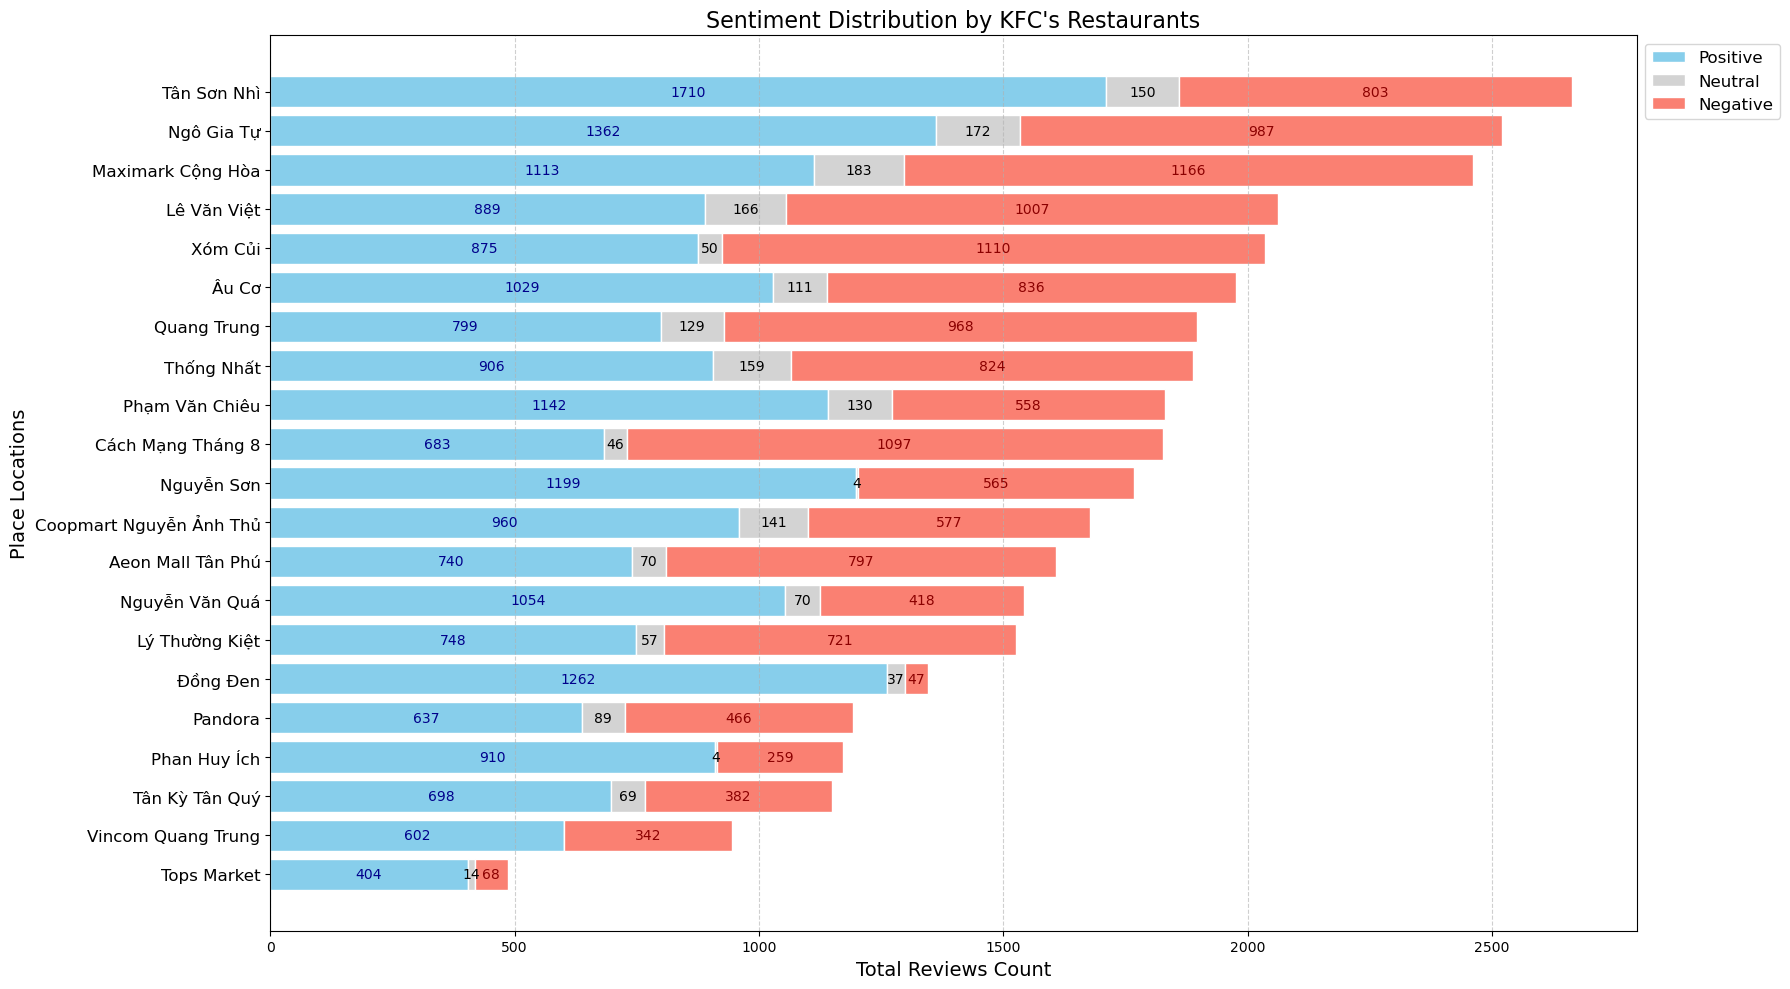

In [87]:
sentiment_by_place = (
    sent_place_df.groupBy("place_name", "sentiment")
    .agg(F.sum("count").alias("total_count"))
    .orderBy("place_name")
)

pdf = sentiment_by_place.toPandas()
pivot_df = pdf.pivot(index="place_name", columns="sentiment", values="total_count").fillna(0)

for sentiment in ['positive', 'neutral', 'negative']:
    if sentiment not in pivot_df.columns:
        pivot_df[sentiment] = 0

# Visualize stacked bar
plt.figure(figsize=(18, 10))
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values('Total', ascending=True)

p1 = plt.barh(pivot_df.index, pivot_df['positive'], 
              color='skyblue', label='Positive', edgecolor='white')
p2 = plt.barh(pivot_df.index, pivot_df['neutral'], 
              left=pivot_df['positive'],
              color='lightgray', label='Neutral', edgecolor='white')
p3 = plt.barh(pivot_df.index, pivot_df['negative'], 
              left=pivot_df['positive'] + pivot_df['neutral'],
              color='salmon', label='Negative', edgecolor='white')

for i, place in enumerate(pivot_df.index):
    # Positive
    if pivot_df['positive'].iloc[i] > 0:
        plt.text(pivot_df['positive'].iloc[i]/2, i,
                str(int(pivot_df['positive'].iloc[i])), 
                va='center', ha='center', color='darkblue', fontsize=10)
    
    # Neutral
    if pivot_df['neutral'].iloc[i] > 0:
        plt.text(pivot_df['positive'].iloc[i] + pivot_df['neutral'].iloc[i]/2, i,
                str(int(pivot_df['neutral'].iloc[i])), 
                va='center', ha='center', color='black', fontsize=10)
    
    # Negative
    total = pivot_df['positive'].iloc[i] + pivot_df['neutral'].iloc[i] + pivot_df['negative'].iloc[i]
    if pivot_df['negative'].iloc[i] > 0:
        plt.text(pivot_df['positive'].iloc[i] + pivot_df['neutral'].iloc[i] + pivot_df['negative'].iloc[i]/2, i,
                str(int(pivot_df['negative'].iloc[i])), 
                va='center', ha='center', color='darkred', fontsize=10)

plt.yticks(range(len(pivot_df.index)), pivot_df.index, fontsize=12)
plt.xlabel('Total Reviews Count', fontsize=14)
plt.ylabel('Place Locations', fontsize=14)
plt.title("Sentiment Distribution by KFC's Restaurants", fontsize=16)
plt.legend(fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Word Count by Rating

In [89]:
rating_df = spark.createDataFrame(
    [Row(word=k[0], rating=k[1], count=v) 
     for k, v in filtered_rating.collect()]
)

print('Top 50 frequency keywords by rating:')
rating_df.orderBy('count', ascending=False).show(50, truncate=False)

Top 50 frequency keywords by rating:
+----------+------+-----+
|word      |rating|count|
+----------+------+-----+
|ngon      |5     |1305 |
|nhân_viên |5     |1267 |
|nhiệt_tình|5     |728  |
|đồ        |5     |685  |
|gà        |5     |537  |
|phục_vụ   |5     |491  |
|nhân_viên |1     |438  |
|dễ_thương |5     |390  |
|thân_thiện|5     |365  |
|gà        |1     |323  |
|món       |5     |293  |
|sạch_sẽ   |5     |280  |
|không_gian|5     |266  |
|quán      |5     |225  |
|kfc       |5     |222  |
|thái_độ   |1     |197  |
|giòn      |5     |195  |
|tệ        |1     |193  |
|đợi       |1     |180  |
|nhà_hàng  |5     |171  |
|đồ        |1     |169  |
|vui_vẻ    |5     |157  |
|món       |1     |156  |
|đi        |1     |150  |
|kfc       |1     |147  |
|mua       |1     |145  |
|nóng      |5     |141  |
|thoáng    |5     |140  |
|quán      |1     |140  |
|mát       |5     |134  |
|đơn       |1     |134  |
|nha       |5     |129  |
|giao      |1     |128  |
|dịch_vụ   |5     |116  |
|

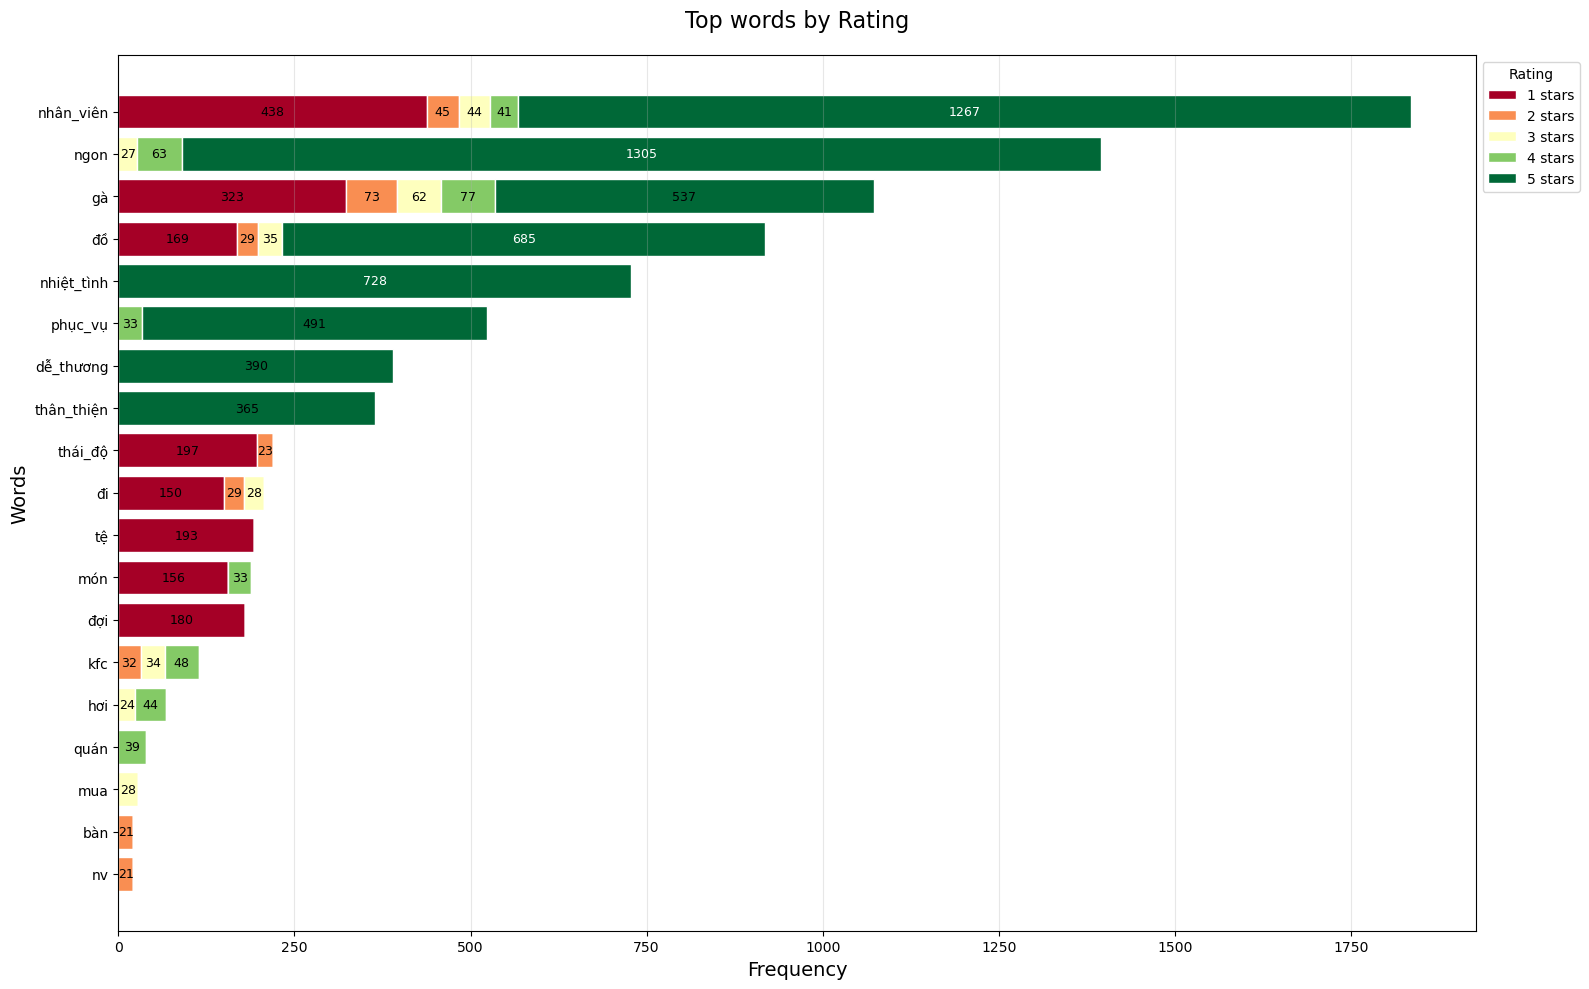

In [90]:
top_words = {}
ratings = [1,2,3,4,5]

for rating in ratings:
    top_words[rating] = (
        rating_df.filter(F.col('rating') == rating)
        .orderBy(F.col('count').desc())
        .limit(8)
        .select('word', 'count')
        .rdd.collectAsMap()
    )

all_words = list(set(
    list(top_words[1].keys()) + 
    list(top_words[2].keys()) + 
    list(top_words[3].keys()) + 
    list(top_words[4].keys()) + 
    list(top_words[5].keys())
))

df_plot = pd.DataFrame({'word': all_words})
for rating in [1, 2, 3, 4, 5]:
    df_plot[f'rating_{rating}'] = [top_words[rating].get(word, 0) for word in all_words]


df_plot['total'] = df_plot[[f'rating_{r}' for r in [1,2,3,4,5]]].sum(axis=1)
df_plot = df_plot.sort_values('total', ascending=True)

# Visualize stacked chart
plt.figure(figsize=(16, 10))
colors = plt.cm.RdYlGn(np.linspace(0, 1, 5))

left = None
for idx, rating in enumerate([1, 2, 3, 4, 5]):
    plt.barh(
        df_plot['word'],
        df_plot[f'rating_{rating}'],
        color=colors[idx],
        label=f'{rating} stars',
        left=left,
        edgecolor='white'
    )
    left = df_plot[f'rating_{rating}'] if left is None else left + df_plot[f'rating_{rating}']

for i, word in enumerate(df_plot['word']):
    width = 0
    for rating in [1, 2, 3, 4, 5]:
        value = df_plot[f'rating_{rating}'].iloc[i]
        if value > 0:
            plt.text(
                width + value/2, i,
                str(int(value)), 
                va='center', ha='center',
                color='white' if value > max(df_plot[[f'rating_{r}' for r in [1,2,3,4,5]]].max())/2 else 'black',
                fontsize=9
            )
            width += value

plt.title('Top words by Rating', fontsize=16, pad=20)
plt.ylabel('Words', fontsize=14)
plt.xlabel('Frequency', fontsize=14)
plt.legend(title='Rating', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()